# Chapter 1: GemPy Basic

In this first example, we will show how to construct a first basic model and the main objects and functions. First we import gempy:

In [15]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")


# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

All data get stored in a python object InputData.  This object can be easily stored in a Python pickle. However, these files have the limitation that all dependecies must have the same versions as those when the pickle were created. For these reason to have more stable tutorials we will generate the InputData from raw data---i.e. csv files exported from Geomodeller.

These csv files can be found in the input_data folder in the root folder of GemPy. These tables contains uniquely the XYZ (and poles, azimuth and polarity in the foliation case) as well as their respective formation name (but not necessary the formation order).


In [16]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50], 
                          path_f = os.pardir+"/input_data/FabLessPoints_Foliations.csv", 
                          path_i = os.pardir+"/input_data/FabLessPoints_Points.csv")

With the command get data is possible to see all the input data. However, at the moment the (depositional) order of the formation and the separation of the series (More explanation about this in the next notebook) is totally arbitrary. 

In [17]:
gp.get_data(geo_data).head()

X     Y      Z azimuth  dip  formation polarity  \
interfaces 0   800   200  -1400     NaN  NaN  Reservoir      NaN   
           1   800  1800  -1400     NaN  NaN  Reservoir      NaN   
           2   600  1000  -1050     NaN  NaN  Reservoir      NaN   
           3   300  1000   -950     NaN  NaN  Reservoir      NaN   
           4  2000  1000  -1275     NaN  NaN  Reservoir      NaN   

                     series  
interfaces 0  Default serie  
           1  Default serie  
           2  Default serie  
           3  Default serie  
           4  Default serie

To set the number of (depositional) series and which formation belongs to which, it is possible to use the function set_series. Here, there are two important things to notice:

- set_series requires a dictionary. In Python dictionaries are not order (keys dictionaries since Python 3.6 are) and therefore there is not guarantee of having the right order.
    + The order of the series are vital for the method (from younger to older).
    + The order of the formations (as long they belong to the correct series) are only important for the color code. If the order of the pile differs from the final result the color of the interfaces and input data will be different

- Every fault is treated as an independent series and **have to be at the top of the pile**. The relative order between the distinct faults represent the tectonic relation between them (from younger to older as well).

The order of the series (for Python < 3.6, otherwise passing the correct order of keys in the dictionary is enough) can be given as attribute as in the cell below. For the order of formations can be passed as attribute as well or using the specific function set_order_formations.

In [18]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest": ('SecondaryReservoir','Seal', 'Reservoir', 'Overlying')},
                       order_series = ["fault", 'Rest'],
                       order_formations=['MainFault', 
                                         'SecondaryReservoir', 'Seal','Reservoir', 'Overlying',
                                         ], verbose=0) 

As an alternative the stratigraphic pile is interactive given the right backend (try %matplotlib notebook or %matplotlib qt5). These backends sometimes give some trouble though. Try to execute the cell twice:

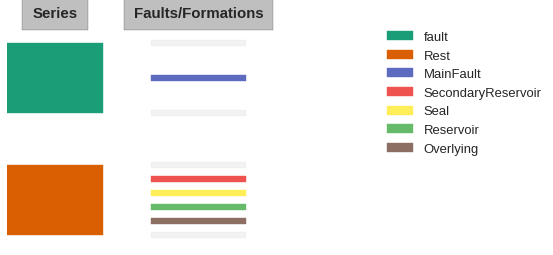

In [19]:
%matplotlib inline
gp.get_sequential_pile(geo_data)

Notice that the colors depends on the order and therefore every time the cell is executed the colors are always in the same position. Be aware of the legend to be sure that the pile is as you wish!! (In the future every color will have the annotation within the rectangles to avoid confusion)

This geo_data object contains essential information that we can access through the correspondent getters. Such a the coordinates of the grid.

In [20]:
print(gp.get_grid(geo_data))

[[    0.             0.         -2000.        ]
 [    0.             0.         -1959.18371582]
 [    0.             0.         -1918.36730957]
 ..., 
 [ 2000.          2000.           -81.63265228]
 [ 2000.          2000.           -40.81632614]
 [ 2000.          2000.             0.        ]]


The main input the potential field method is the coordinates of interfaces points as well as the orientations. These pandas dataframes can we access by the following methods:

#### Interfaces Dataframe

In [21]:
gp.get_data(geo_data, 'interfaces').head()

,X,Y,Z,formation,series
0,1000,1000,-1000,MainFault,fault
1,800,1000,-1600,MainFault,fault
2,1200,1000,-400,MainFault,fault
3,1100,1000,-700,MainFault,fault
4,900,1000,-1300,MainFault,fault


#### Foliations Dataframe

Now the formations and the series are correctly set.

In [22]:
gp.get_data(geo_data, 'orientations').head()

,X,Y,Z,dip,azimuth,polarity,formation,series
0,917.45,1000,-1135.4,71.565,270,1,MainFault,fault
1,1450,1000,-1150,18.435,90,1,Reservoir,Rest


It is important to notice the columns of each data frame. These not only contains the geometrical properties of the data but also the **formation** and **series** at which they belong. This division is fundamental in order to preserve the depositional ages of the setting to model.

A projection of the aforementioned data can be visualized in to 2D by the following function. It is possible to choose the direction of visualization as well as the series:

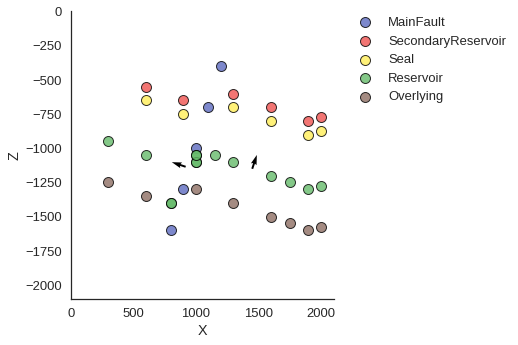

In [23]:
%matplotlib inline
gp.plot_data(geo_data, direction='y')
import matplotlib.pyplot as plt


GemPy supports visualization in 3D as well trough vtk. These plots are interactive. Try to drag and drop a point or interface! In the perpendicular views only 2D movements are possible to help to place the data where is required.

In [24]:
gp.plot_data_3D(geo_data)

## The ins and outs of Input data objects

As we have seen objects DataManagement.InputData (usually called geo_data in the tutorials) aim to have all the original geological properties, measurements and geological relations stored. 

Once we have the data ready to generate a model, we will need to create the next object type towards the final geological model:

In [27]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1,1], compile_theano=True, theano_optimizer='fast_run')
print(interp_data)

Level of Optimization:  fast_run
Device:  cpu
Precision:  float32


In [16]:
interp_data.geo_data_res.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'Overlying': 5,
 'Reservoir': 4,
 'Seal': 3,
 'SecondaryReservoir': 2}


By default (there is a flag in case you do not need) when we create a interp_data object we also compile the theano function that compute the model. That is the reason why takes long.

gempy.DataManagement.InterpolatorInput (usually called interp_data in the tutorials) prepares the original data to the interpolation algorithm by scaling the coordinates for better and adding all the mathematical parametrization needed.


In [17]:
gp.get_kriging_parameters(interp_data)

range 0.8882311582565308 3464.1015172
Number of drift equations [0 3]
Covariance at 0 0.01878463476896286
orientations nugget effect 0.009999999776482582


 These later parameters have a default value computed from the original data or can be changed by the user (be careful of changing any of these if you do not fully understand their meaning).
 
At this point, we have all what we need to compute our model. By default everytime we compute a model we obtain:

- Lithology block model
    + with the lithology values in 0
    + with the potential field values in 1
- Fault block model
    + with the faults zones values (i.e. every divided region by each fault has one number) in 0
    + with the potential field values in 1

In [14]:

lith_block, fault_block = gp.compute_model(interp_data)

In [28]:
%%timeit

lith_block, fault_block = gp.compute_model(interp_data)

224 ms ± 9.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This solution can be plot with the correspondent plotting function. Blocks:

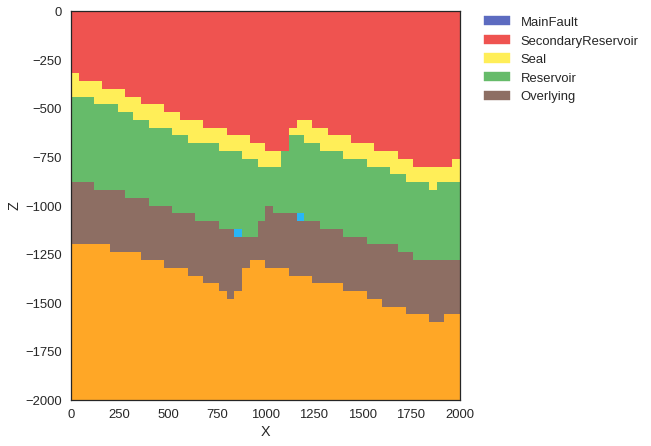

In [19]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], 25, plot_data=False)

Potential field:

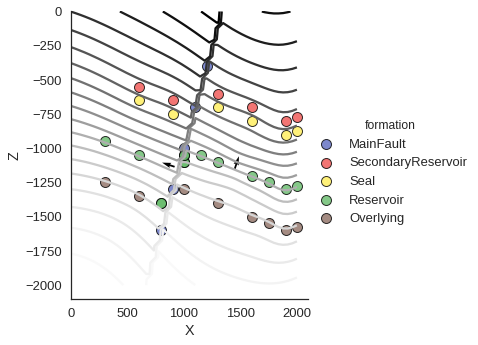

In [20]:
gp.plot_scalar_field(geo_data, lith_block[1], 25)

From the potential fields (of lithologies and faults) it is possible to extract vertices and simpleces to create the 3D triangles for a vtk visualization.

In [33]:
np.unique(fault_block[1])

array([ 0.], dtype=float32)

In [21]:
ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)

# In python is very easy to export data using for example:
# np.save('ver_fabian', ver)
# np.save('sim_fabian', sim)

In [24]:
gp.plot_surfaces_3D(geo_data, ver, sim, alpha=1)

The vertices always cut the edges of the cells. In the next cell we can see how vertices and voxels relates:

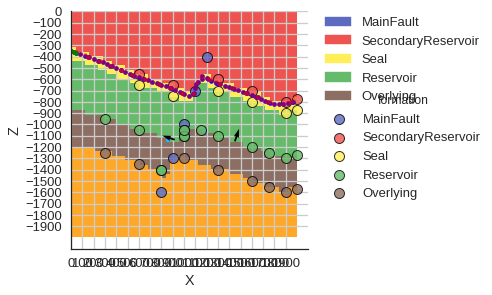

In [25]:
# Cropping a cross-section to visualize in 2D
bool_b = np.array(ver[1][:,1] > 999)* np.array(ver[1][:,1] < 1001) 
bool_r = np.array(ver[1][:,1] > 1039)* np.array(ver[1][:,1] < 1041)

# Plotting section
import matplotlib.pyplot as plt
gp.plot_section(geo_data, lith_block[0], 25, plot_data=True)
ax = plt.gca()

# Adding grid
ax.set_xticks(np.linspace(0, 2000, 20, endpoint=False))
ax.set_yticks(np.linspace(0, -2000, 20, endpoint=False))
plt.grid()

# Plotting vertices
ax.plot(ver[1][bool_b][:, 0], ver[1][bool_b][:, 2], '.', color='b')
ax.plot(ver[1][bool_r][:, 0], ver[1][bool_r][:, 2], '.', color='r', alpha=.5)

# Plotting an example of a triangle
ax.plot(ver[1][[61,62,63], 0], ver[1][[61,62,63], 2], '.', color='g')

Additionally is possible to update the model and recompute the surfaces in real time. To do so, we need to pass the data rescaled. To get an smooth response is important to have the theano optimizer flag in fast_run and run theano in the gpu. This can speed up the modeling time in a factor of 20.

In [26]:
ver_s, sim_s = gp.get_surfaces(interp_data,lith_block[1],
                               fault_block[1],
                               original_scale=False)

In [27]:
gp.plot_surfaces_3D_real_time(interp_data, ver_s, sim_s)

In the same manner we can visualize the fault block:

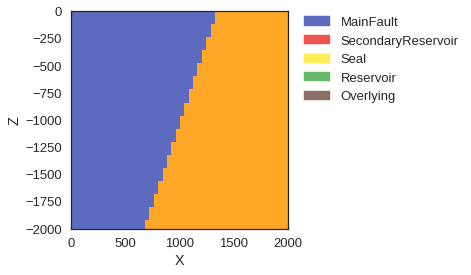

In [22]:
gp.plot_section(geo_data, fault_block[0], 25)

In [28]:
gp.plot_potential_field(geo_data, fault_block[1], 25)

AttributeError: module 'gempy' has no attribute 'plot_potential_field'

In [30]:
steno_model = gp.steno3D(geo_data)

In [ ]:
steno_model.plot3D_steno(lith_block[0], 'ch1')